# Question :

Est-ce que le traffic de drogue et le traffic d'armes sont liés ?
---

In [5]:
import json
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

# Initialisation des fonction utiles
---

In [6]:
def creation_geojson(df_names: pd.DataFrame, WorldMapJson) -> dict:
    """
    Création d'un GeoJson à partir d'un DataFrame et d'un GeoJson
    """
    # Création du GeoJson avec les pays que l'on a dans notre df
    WorldMap = {"type": "FeatureCollection", "features": []}

    id = [i for i in range(1,len(df_names)+1)]
    name = [name for name in df_names.index]
    value = [df_names[name] for name in df_names.index]

    # Formatage des données du GeoJson pour les pays que l'on a dans un autre GeoJson pour qu'il correspond avec notre df
    for i in range (1,len(name)+1):
        pays = {}
        pays["type"] = "Feature"
        pays["id"] = i
        geo = {}
        for y in range(len(WorldMapJson["features"])):
            if WorldMapJson["features"][y]["properties"]["geounit"] in name[i-1] or name[i-1] in WorldMapJson["features"][y]["properties"]["geounit"] or name[i-1] in WorldMapJson["features"][y]["properties"]["name_tr"]:
                pays["name"] = WorldMapJson["features"][y]["properties"]["geounit"]
                pays["geometry"] = WorldMapJson["features"][y]["geometry"]
                WorldMap["features"].append(pays)

    return WorldMap, pd.DataFrame({"id": id, "name": name, "value": value})

# Lecture des fichiers
---

**Lecture du geojson global**

In [7]:
# Lecture du fichier GeoJson
with open('../DM/data/World.json', encoding='utf8') as f:
    WorldMapJson = json.load(f)

# Création d'un DataFrame avec les pays et les continents pour merge avec les autres df
df_pays_region = pd.DataFrame({
    "Pays": [i['properties']['name'] for i in WorldMapJson['features']],
    "Continent": [i['properties']['continent'] for i in WorldMapJson['features']]
})
df_pays_region["Continent"].unique()

array(['North America', 'South America', 'Asia', 'Africa', 'Europe',
       'Oceania'], dtype=object)

**Lecture du fichier excel des armes**

In [8]:
df_armes = pd.read_excel('data_iafq_firearms_trafficking.xlsx', engine='openpyxl')
print(df_armes.shape)
df_armes.head()
# Temps :

(15468, 13)


,Iso3_code,Country,Region,Subregion,Indicator,Dimension,Category,Sex,Age,Year,Unit of measurement,VALUE,Source
0,ALB,Albania,Europe,Southern Europe,Ammunition seized,Total,Total,na,na,2022,Counts,27806,IAFQ
1,ALB,Albania,Europe,Southern Europe,Arms found,by marking,no marking,na,na,2022,Counts,3,IAFQ
2,ALB,Albania,Europe,Southern Europe,Arms found,by marking,Total,na,na,2022,Counts,18,IAFQ
3,ALB,Albania,Europe,Southern Europe,Arms found,by marking,uniquely marked,na,na,2022,Counts,15,IAFQ
4,ALB,Albania,Europe,Southern Europe,Arms found,by type,other weapons,na,na,2022,Counts,11,IAFQ


**Lecture du fichier excel des drogues**

In [9]:
df_drogues = pd.read_excel('7.1._Drug_seizures_2018-2022.xlsx', engine='openpyxl')
print(df_drogues.shape)
df_drogues.head()
# Temps :

(11013, 9)


,Region,SubRegion,Country,DrugGroup,DrugSubGroup,DrugName,Reference year,Kilograms,msCode
0,Africa,East Africa,Kenya,Amphetamine-type stimulants (excluding “ecstasy”),Methamphetamine,Methamphetamine,2022,10.84,KEN
1,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis herb (marijuana),Cannabis herb (marijuana),2022,8474.41,KEN
2,Africa,East Africa,Kenya,Cannabis-type drugs (excluding synthetic canna...,Cannabis plants,Cannabis plants,2022,2534.40,KEN
3,Africa,East Africa,Kenya,Cocaine-type,Cocaine,Cocaine hydrochloride,2022,10.99,KEN
4,Africa,East Africa,Kenya,Opioids,Opiates,Heroin,2022,38.94,KEN


# Création des datasets pour les graphique
---

**Répartition des armes saisies par régions :**\
Ce dataset sera utilisé pour créer un graphique en forme de donut sur la répartition des armes entre les différentes régions du monde.

In [10]:
df_donut_weapons = df_armes[['Region', 'VALUE']].dropna()

df_donut_weapons['VALUE'] = pd.to_numeric(df_donut_weapons['VALUE'], errors='coerce')

data_donut_weapons = df_donut_weapons.groupby("Region")["VALUE"].sum()

**Répartition des kilogrammes de drogues saisies par régions :**\
Ce dataset sera utilisé pour créer un graphique en forme de donut sur la répartition des kilogrammes de drogues saisis entre les différentes régions du monde.

In [11]:
df_donut_drugs = df_drogues[['Region', 'Kilograms']].dropna()

df_donut_drugs['Kilograms'] = pd.to_numeric(df_donut_drugs['Kilograms'], errors='coerce')

data_donut_drugs = df_donut_drugs.groupby("Region")["Kilograms"].sum()

**Ensemble des saisies de drogue entre les années 2018 et 2022 :**\
Le dataset suivant va nous permettre de créer une ligne d'évolution de l'ensemble des saisies de drogue en fonction des années.

In [12]:
# Convertir la colonne 'Kilograms' en numérique (gérer les erreurs éventuelles)
data_drugs = df_drogues.copy()
data_drugs["Kilograms"] = pd.to_numeric(data_drugs["Kilograms"], errors="coerce")
data_drugs["Reference year"] = pd.to_numeric(data_drugs["Reference year"], errors="coerce")

# Regrouper les données par année
kg_drugs_per_year = data_drugs.groupby("Reference year")["Kilograms"].sum()

**Ensemble des saisies d'armes entre les années 2012 et 2022 :**\
Le dataset suivant va nous permettre de créer une ligne d'évolution de l'ensemble des saisies d'armes en fonction des années.

In [13]:
# Convertir les colonnes en numérique
data_firearms = df_armes.copy()
data_firearms["VALUE"] = pd.to_numeric(data_firearms["VALUE"], errors="coerce")
data_firearms["Year"] = pd.to_numeric(data_firearms["Year"], errors="coerce")

# Supprimer les NaN dans 'Year' et convertir en entier
data_firearms = data_firearms.dropna(subset=["Year"])
data_firearms["Year"] = data_firearms["Year"].astype(int)

# Filtrer les années entre 2012 et 2022
data_filtered = data_firearms[(data_firearms["Year"] >= 2012) & (data_firearms["Year"] <= 2022)]

# Regrouper les données par année
nbr_weapons_per_year = data_filtered.groupby("Year")["VALUE"].sum()

**Rang des saisies de drogue selon différentes régions**\
Le dataset suivant regroupe l'ensemble des saisies de drogues selon la région. Cela va nous permettre de bien observer quelles sont les régions les plus touchées par le trafic de drogues.

In [14]:
ranking_region = df_drogues.groupby("Region")["Kilograms"].sum()
ranking_region = ranking_region[ranking_region != 0]
ranking_region = ranking_region.sort_values(ascending=False)
print(ranking_region)

Region
Americas    5.206251e+07
Europe      4.398714e+07
Asia        3.237204e+07
Africa      1.698736e+07
Oceania     3.080453e+05
Name: Kilograms, dtype: float64


**Rang des saisies d'armes selon différentes régions**\
Le dataset suivant regroupe l'ensemble des saisies d'armes selon la région. Cela va nous permettre de bien observer quelles sont les régions les plus touchées par le trafic d'armes.

In [15]:
ranking_region_fire = data_firearms.groupby("Region")["VALUE"].sum()
ranking_region_fire = ranking_region_fire[ranking_region_fire != 0]
ranking_region_fire = ranking_region_fire.sort_values(ascending=False)
print(ranking_region_fire)

Region
Americas    25648556
Asia        17341510
Europe       7874983
Oceania      6306210
Africa       1352250
Name: VALUE, dtype: int64


**Répartition des armes saisies par pays :** \
Ce dataset sera utilisé pour créer une carte du monde avec une couleur attribuée à chaque pays en fonction du nombre d'armes saisie par la police.\
\
Les valeurs des Etats-Unis d'Amerique et de la Colombie sont tellement élevées qu'on a décidé de les enlever du graphique final pour avoir une meilleure compréhension de ce dernier. Evidement, les deux pays seront pris en compte dans notre analyse finale. \
\
Cette cellule nous permet de créer le dataset et le geojson associé pour faire notre carte du monde.

In [16]:
df_weapons_filter_for_map = df_armes[df_armes["Country"] != "United States of America"] # On retire les USA car ils faussent les graphiques
df_weapons_filter_for_map = df_weapons_filter_for_map[df_weapons_filter_for_map["Country"] != "Colombia"] # On retire la Colombie car ils faussent les graphiques
df_weapons_filter_for_map = df_weapons_filter_for_map[df_weapons_filter_for_map["Indicator"] == "Arms seized"]
df_weapons_filter_for_map = df_weapons_filter_for_map[df_weapons_filter_for_map['Dimension'] == 'Total']
df_weapons_filter_for_map = df_weapons_filter_for_map[df_weapons_filter_for_map['Category'] == 'Total']
total_seized_weapons = df_weapons_filter_for_map.groupby("Country")["VALUE"].sum() # (111, 2)

WorldMapJson_weapons, df_map_weapons = creation_geojson(total_seized_weapons, WorldMapJson)
# print(WorldMapJson_weapons) # Geojson avec les pays pour lesquels nous avons des données
print(df_map_weapons.shape) # (111, 3)
df_map_weapons.head()

(109, 3)


,id,name,value
0,1,Albania,3248
1,2,Algeria,2891
2,3,Andorra,66
3,4,Angola,25494
4,5,Antigua and Barbuda,28


**Répartition des drogues saisies par pays (en tonnes) :** \
Ce dataset sera utilisé pour créer une carte du monde avec une couleur attribuée à chaque pays en fonction du nombre de tonnes de drogue saisie par la police. \
\
Les valeurs de la Turquie, de l'Inde et de la Colombie sont tellement élevées qu'on a décidé de les enlever du graphique final pour avoir une meilleure compréhension de ce dernier. Evidement, les trois pays seront pris en compte dans notre analyse finale. \
\
Cette cellule nous permet de créer le dataset et le geojson associé pour faire notre carte du monde.

In [17]:
total_seized_drugs = df_drogues[df_drogues["Country"] != "Türkiye"] # On retire la Turquie car elle fausse les graphiques
total_seized_drugs = total_seized_drugs[total_seized_drugs["Country"] != "India"] # On retire la Turquie car elle fausse les graphiques
total_seized_drugs = total_seized_drugs[total_seized_drugs["Country"] != "Colombia"] # On retire la Turquie car elle fausse les graphiques
total_seized_drugs = total_seized_drugs.groupby("Country")["Kilograms"].sum() / 1000 # groupby + Conversion des valeurs en tonnes

WorldMapJson_drugs, df_map_drugs = creation_geojson(total_seized_drugs, WorldMapJson)
# print(WorldMapJson_drugs) # Geojson avec les pays pour lesquels nous avons des données
print(df_map_drugs.shape) # (156, 3)
df_map_drugs.head()

(153, 3)


,id,name,value
0,1,Afghanistan,2009.090133
1,2,Albania,149.193012
2,3,Algeria,314.895703
3,4,Andorra,0.045450
4,5,Angola,14.613000


# Graphiques
---

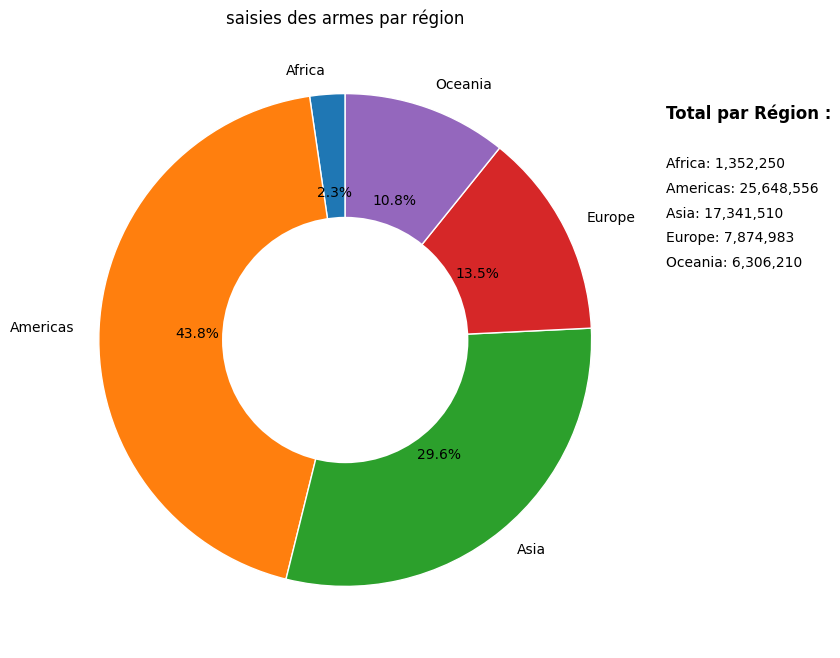

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    data_donut_weapons, labels=data_donut_weapons.index, autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
ax.add_artist(plt.Circle((0, 0), 0.5, fc='white'))

text_x = 1.3
text_y = 0.8
line_spacing = 0.1
plt.text(text_x, text_y + 0.1, "Total par Région :", fontsize=12, fontweight='bold', ha='left')
for region, value in data_donut_weapons.items():
    text_y -= line_spacing
    plt.text(text_x, text_y, f"{region}: {value:,.0f}", fontsize=10, ha='left')

plt.title("saisies des armes par région")

plt.show()

Ce graphique montre la répartition des saisies d’armes par région. Les Amériques enregistrent la plus grande quantité d’armes saisies, avec des circuits de trafic reliant divers pays du continent. L’Asie suit, avec une circulation importante d’armes liée à des conflits et au commerce illégal. L’Europe est également concernée, bien que les régulations y soient plus strictes. L’Afrique et l’Océanie présentent des volumes de saisies plus faibles, l’Afrique étant aussi une zone de transit pour le trafic.

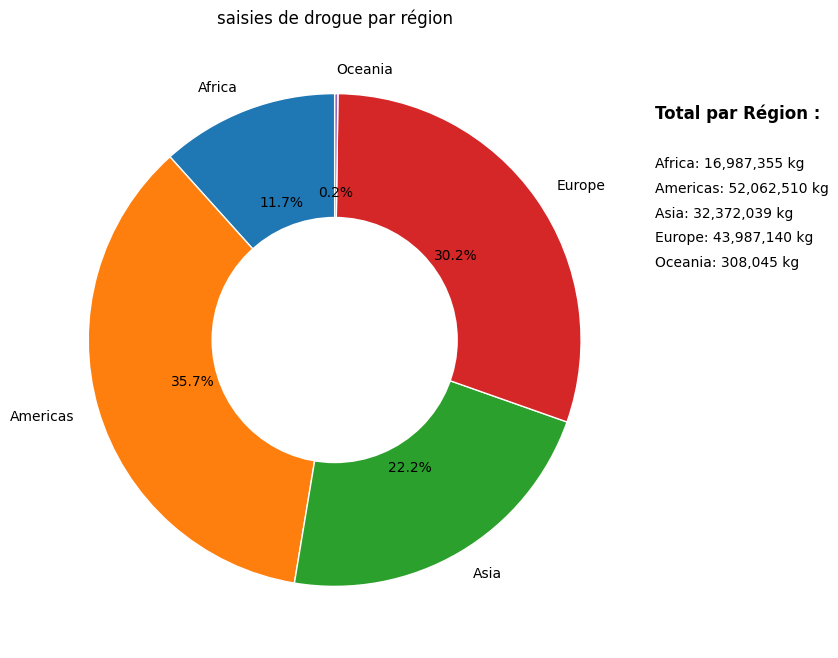

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    data_donut_drugs, labels=data_donut_drugs.index, autopct='%1.1f%%', startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
ax.add_artist(plt.Circle((0, 0), 0.5, fc='white'))

text_x = 1.3
text_y = 0.8
line_spacing = 0.1

plt.text(text_x, text_y + 0.1, "Total par Région :", fontsize=12, fontweight='bold', ha='left')
for region, value in data_donut_drugs.items():
    text_y -= line_spacing
    plt.text(text_x, text_y, f"{region}: {value:,.0f} kg", fontsize=10, ha='left')

plt.title("saisies de drogue par région")

plt.show()

Ce graphique montre la répartition des saisies de drogue par région. Les Amériques enregistrent la plus grande quantité de drogue saisie, avec des routes de trafic reliant l’Amérique du Sud, productrice, à l’Amérique du Nord, consommatrice. L’Europe suit de près, étant une destination majeure pour les trafics en provenance d’Amérique Latine, d’Afrique de l’Ouest et d’Asie. L’Asie joue un rôle clé dans la production et la distribution, avec des flux en direction de l’Europe et des États-Unis. L’Afrique sert de zone de transit.

---
L'analyse des deux graphiques montre une corrélation entre les saisies d’armes et de drogue par région. Les Amériques enregistrent les volumes les plus élevés pour les deux types de trafic, indiquant une présence marquée de flux illicites dans cette zone. L’Europe et l’Asie occupent également des positions importantes dans les deux classements, suggérant une convergence des routes de circulation. L’Afrique apparaît comme une zone de transit dans les deux cas, avec des quantités saisies plus faibles mais néanmoins présentes. L’Océanie reste marginale dans les deux trafics, avec des volumes bien inférieurs aux autres régions.

**Graphique d'évolutions de drogues par année**\
Le graphique suivant va nous permettre d'observer l'évolution concernant la saisie de drogue par année.


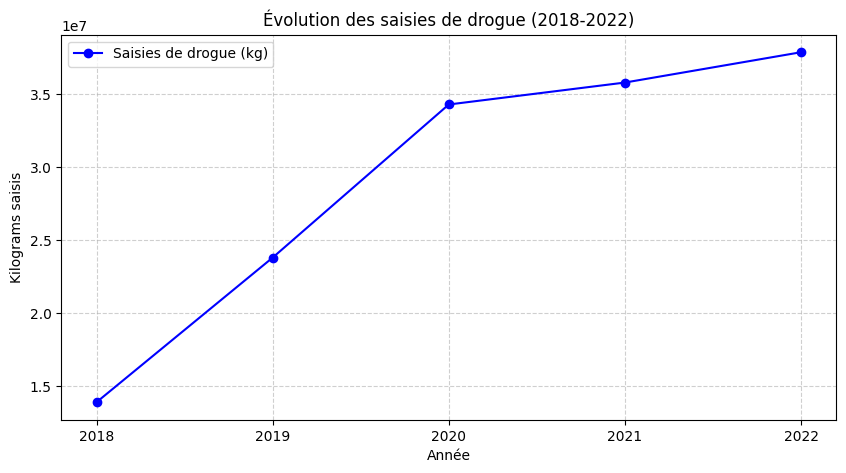

In [20]:
# Tracer le graphique d'évolution
plt.figure(figsize=(10, 5))
plt.plot(kg_drugs_per_year.index, kg_drugs_per_year.values, marker="o", linestyle="-", color="b", label="Saisies de drogue (kg)")

# Ajouter des titres et labels
plt.title("Évolution des saisies de drogue (2018-2022)")
plt.xlabel("Année")
plt.ylabel("Kilograms saisis")
plt.xticks(kg_drugs_per_year.index)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Afficher le graphique
plt.show()

On observe bien que plus les années passent et plus elle ne cesse d'augmenter. 
On voit bien qu'entre les années 2018 et 2020, les saisies de drogue rencontrent une forte augmentation, à ce moment-là les saisies ont plus que doublé.


**Graphique d'évolutions d'armes par année**\
Le graphique suivant va nous permettre d'observer l'enssemble de l'évolution concernant la saisie d'armes par année.

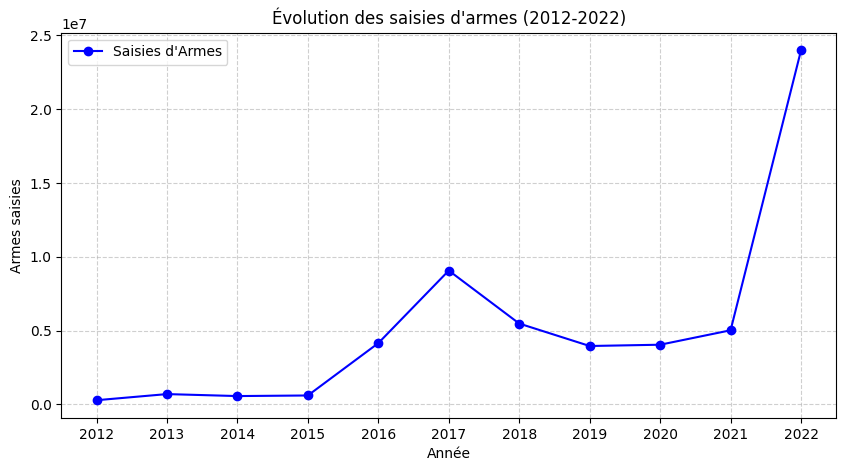

In [21]:
# Tracer le graphique d'évolution
plt.figure(figsize=(10, 5))
plt.plot(nbr_weapons_per_year.index, nbr_weapons_per_year.values, marker="o", linestyle="-", color="b", label="Saisies d'Armes")

# Ajouter des titres et labels
plt.title("Évolution des saisies d'armes (2012-2022)")
plt.xlabel("Année")
plt.ylabel("Armes saisies")
plt.xticks(nbr_weapons_per_year.index)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Afficher le graphique
plt.show()


Au début d'année, on observe une très faible saisie des armes qui rencontre une hausse dans les années 2016 et 2017.
Elle finit par baisser l'égerment et à stagner quelques années avant de rencontrer une augmentation de saisie en 2022 qui a plus que triplé.

Malgré que mes deux graphiques ont des années différentes, on observe une augmentation par rapport aux premières années.
On observe aussi qu'en 2022, les trafics d'armes et de drogues rencontrent une véritable augmentation avec le pic le plus élevé rencontré.
On peut donc conclure que le trafic de drogues et d'armes est en quelque sorte lié.

**Ranking saisies de drogue par région**\
Le graphique suivant va nous permettre d'observer le rang des régions concernant la saisie de drogue.

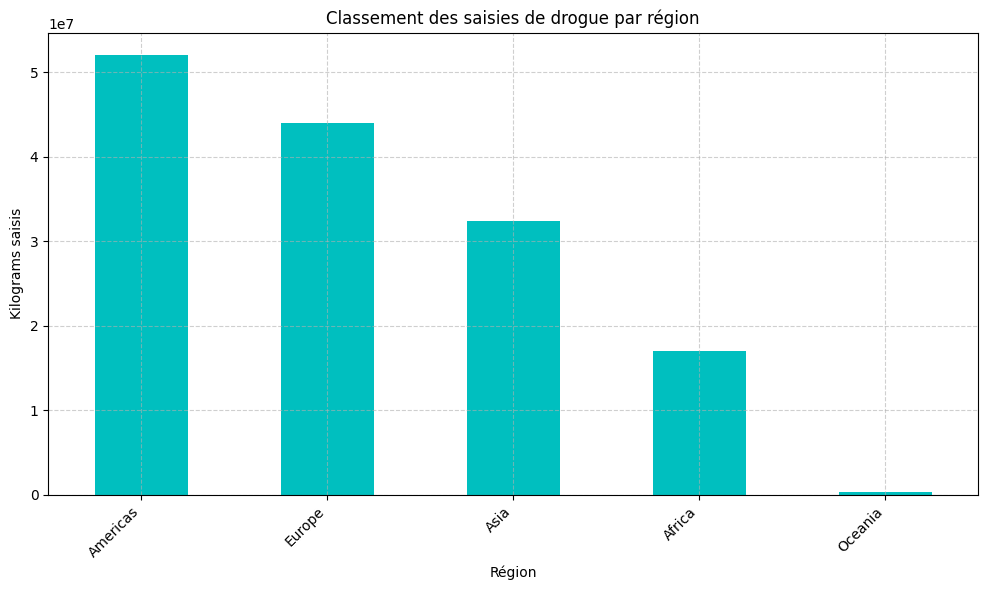

In [22]:
# Tracer le classement
plt.figure(figsize=(12, 6))
ranking_region.plot(kind="bar", color="c")
plt.title("Classement des saisies de drogue par région")
plt.xlabel("Région")
plt.ylabel("Kilograms saisis")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Sur ce graphique, on observe une forte saisie de drogue en Amérique et en Europe, en Océanie par contre on voit que cela est moindre.

**Ranking saisies d'armes par région**\
Le graphique suivant va nous permettre d'observer le rang des régions concernant la saisie d'arme.

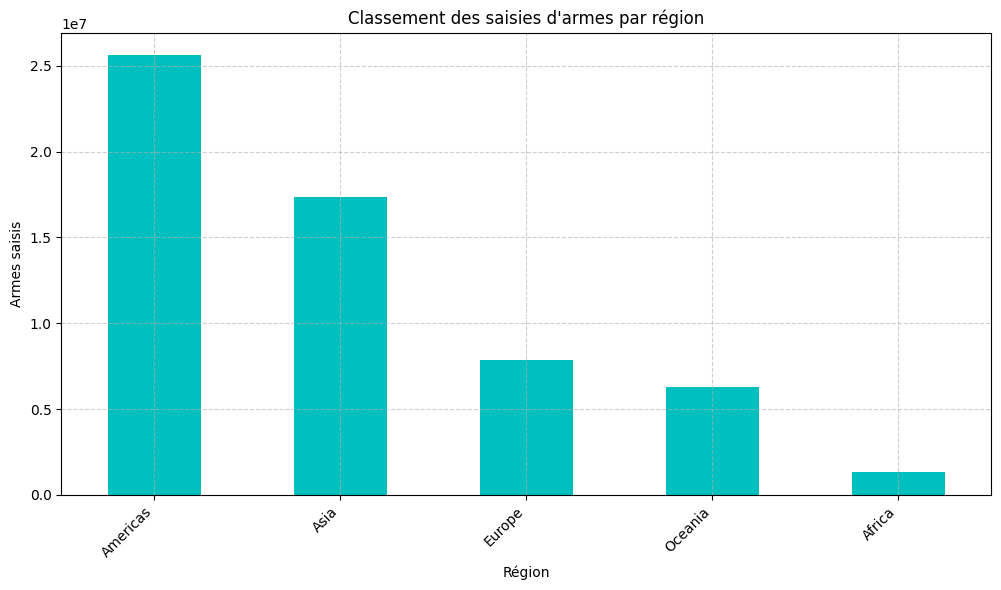

In [23]:
# Tracer le classement
plt.figure(figsize=(12, 6))
ranking_region_fire.plot(kind="bar", color="c")
plt.title("Classement des saisies d'armes par région")
plt.xlabel("Région")
plt.ylabel("Armes saisis")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Sur ce graphique, on observe une forte saisie d'armes en Amérique et en Asie, en Afrique par contre on voit que cela est moindre.

Sur les deux graphiques, nous pouvons retrouver l'Amérique en première position en ce qui concerne les saisies de drogues et d'armes. Cela est dû au fait que le trafic d'armes et de drogues là-bas est plus égal que dans les autres régions. Il existe un réel marché et une forte demande concernant celle-ci.En plus de cela, les pays qui jouent un rôle majeur dans le trafic d'armes et de drogue se trouvent dans la région d'Amérique. Cela explique pourquoi les Amériques se retrouvent premières dans le classement.


**Carte du monde en fonction de la saisie des armes :**

In [24]:
# Weapons 
fig1 = px.choropleth( # Construction du choropleth
    df_map_weapons,
    geojson=WorldMapJson_weapons,
    locations='id',
    color='value',
    color_continuous_scale="Viridis", # "Viridis" "Cividis" "inferno_r" "magma_r" "plasma_r" "inferno_r"
    range_color=(0, max(total_seized_weapons.values.tolist())),
    projection="natural earth",
    title="Nombre total d'armes saisies légalement par pays",
)
fig1.update_layout(margin={"r":0,"t":30,"l":0,"b":0})


fig1.update_layout( # Legende
    coloraxis_colorbar=dict(
    thicknessmode="pixels", thickness=15,
    lenmode="pixels", len=350,
    yanchor="top", y=0.8,
    ticks="outside",
    dtick=5
))

fig1.show()

- On voit que les régions avec le plus grand nombre d'armes saisies sont l'Amérique du Nord, l'Amérique du Sud et l'Australie. \
- On voit aussi que beaucoup d'armes sont saisies en Espagne et en Russie.

**Carte du monde en fonction de la saisie des drogues :**

In [25]:
# Drugs
fig2 = px.choropleth( # Construction du choropleth
    df_map_drugs,
    geojson=WorldMapJson_drugs,
    locations='id',
    color='value',
    color_continuous_scale="Viridis", # "Viridis" "Cividis" "inferno_r" "magma_r" "plasma_r" "inferno_r"
    range_color=(0, max(total_seized_drugs.values.tolist())),
    projection="natural earth",
    title="Nombre total de drogues saisies par pays",
)
fig2.update_layout(margin={"r":0,"t":30,"l":0,"b":0})


fig2.update_layout( # Legende
    coloraxis_colorbar=dict(
    thicknessmode="pixels", thickness=15,
    lenmode="pixels", len=350,
    yanchor="top", y=0.8,
    ticks="outside",
    dtick=5
))

fig2.show()

- On voit que les régions avec les plus grandes saisies de drogues sont l'Amérique du Nord, l'Amérique du Sud et le Moyen-Orient. \
- On voit aussi que beaucoup de tonnes de drogues sont saisie en Espagne, en Inde, au Niger et en Tanzanie

---
- On remarque que les couleurs des pays correspondent plutôt bien entre les deux graphiques.
- Cependant, certains pays ont quand même une plus forte saisie d'arme que de drogue telle que la Russie ou bien l'Australie et cela pourrait s'expliquer par la présence d'autres traffic dans ces pays.

# Conclusion
---
...
On peut donc en conclure que le trafic de drogues et d'armes est lié. On a bien observé le cas en Amérique où la saisie des drogues et des armes est la plus élevée. Cela nous montre bien que les deux trafics ont un certain lien. Ils jouent un rôle majeur dans l'économie du pays.
...\
\
Il est comme même important de rappeler que ces chiffres sont ceux de L'ONU et ils ne représentent que le nombre d'armes et le nombre de tonnes de drogues saisies par les polices du monde. Nous pensons qu'ils ne sont pas forcément représentatifs de la réalité et de nombreux paramètres sont manquants pour avoir une analyse complète de la situation du traffic d'arme et de drogue mondiale.